# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description
**Team :** Group 5

**Authors :** Chun-Hung Yeh, Kuan Tung, Zhuoyue Wang 

**Due date :** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

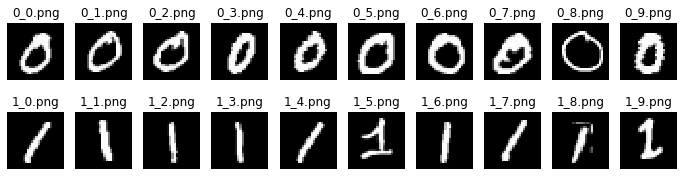

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

#### 1.2.1 Normal fourier descriptors

In [4]:
def findContour(im, threshold):
    '''
        Find contour of handwriting number.
    '''
    # Threshold extracting
    im = im > threshold
    label_img = skimage.measure.label(im>0)
    
    # Region growing and get the largest region
    regions=skimage.measure.regionprops(label_img)
    areas = np.array([region.area for region in regions])
    sort_list = np.argsort(areas)[::-1]
    
    # Set the largest region to value '1', others 0
    temp = np.full_like(label_img, False)
    for coord in regions[sort_list[0]].coords:
        temp[coord[0]][coord[1]]=True
    im = temp
    
    # Find the contour of largest region
    contours = find_contours(im, level)
    contour = contours[0]
    
    return contour

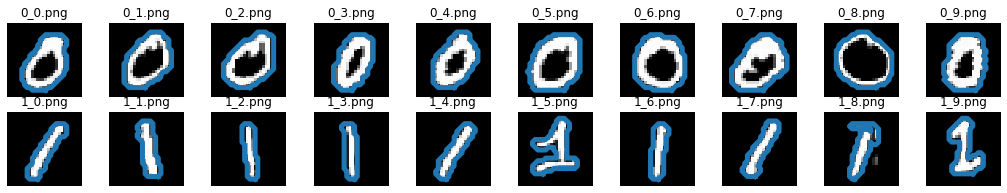

In [5]:
import numpy as np
import skimage.transform as transform
from skimage.measure import find_contours

level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

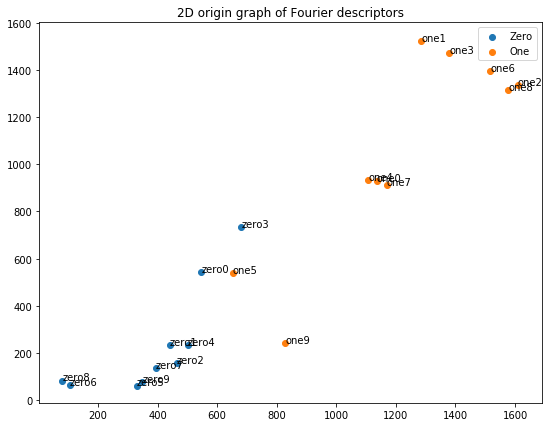

In [68]:
def visFourier(contours_0, contours_1, max_freq=150, text='Origin', component_1=1, component_2=2):
    '''
        contours_0: Contour list of zero images
        contours_1: Contour list of zero images
        max_freq: The frequecy of fourier transformation
        component_1, component_2: Two components of Fourier desciptors used for classfication.
    '''
    # Fourier transformation for images
    zeros_dft, ones_dft = [], []
    zeros_mag, ones_mag = [], []

    # Set the freqency for the Fourier transformation
    for zero, one in zip(contours_0, contours_1):
        zero = [np.complex(cord[0], cord[1]) for cord in zero]
        zero_dft = np.fft.fft(zero, n=max_freq)
        zeros_dft.append(zero_dft)
        zeros_mag.append((np.abs(zero_dft[component_1]), np.abs(zero_dft[component_2])))

        one = [np.complex(cord[0], cord[1]) for cord in one]
        one_dft = np.fft.fft(one, n=max_freq)
        ones_dft.append(one_dft)
        ones_mag.append((np.abs(one_dft[component_1]), np.abs(one_dft[component_2])))

    # Visualize the first two components of Fourier descriptors
    plt.figure(figsize=(9, 7))
    plt.scatter([cord[0] for cord in zeros_mag], [cord[1] for cord in zeros_mag], label='Zero')
    plt.scatter([cord[0] for cord in ones_mag], [cord[1] for cord in ones_mag], label='One')
    plt.legend()
    plt.title("2D " + text + " graph of Fourier descriptors")
    for i, (zero, one) in enumerate(zip(zeros_mag, ones_mag)):
        plt.annotate('zero'+str(i), (zero[0], zero[1]), )
        plt.annotate('one'+str(i), (one[0], one[1]))
    plt.show()

visFourier(contours_0, contours_1, 150, 'origin')

#### 1.2.2 Fourier descriptors for **rotated image classification**

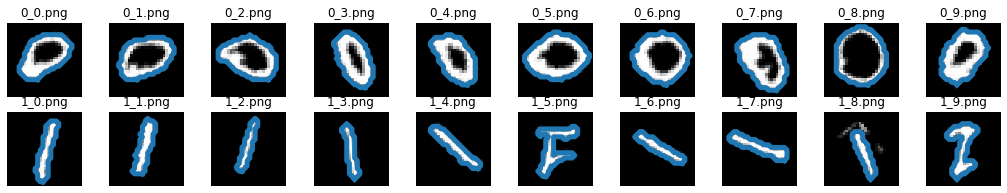

In [69]:
# Randomly rotate images 
import random

level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    degrees = random.randint(0, 180)
    im = transform.rotate(im, degrees)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    degrees = random.randint(0, 180)
    im = transform.rotate(im, degrees)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

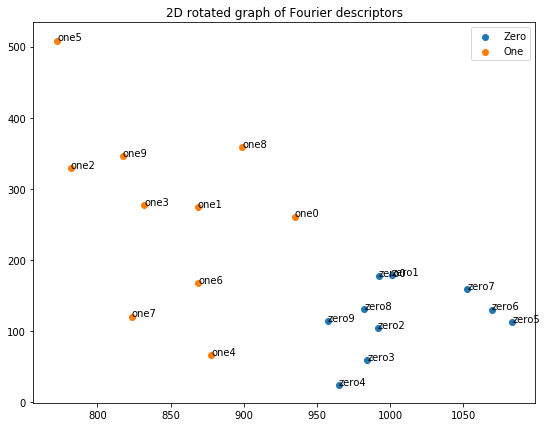

In [70]:
visFourier(contours_0, contours_1, 150, 'rotated')

#### 1.2.4 Fourier descriptors for **Randomly translate images**

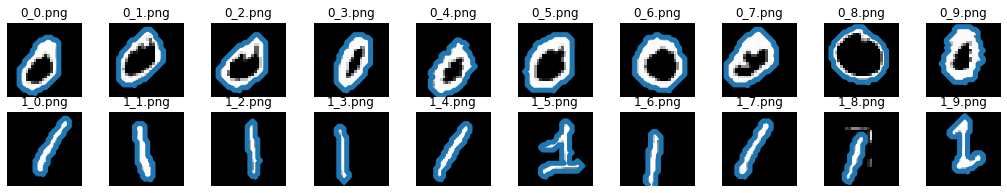

In [71]:
# Randomly translate images, but always keep numbers in sight to maintain the shape infomation
import random

level = 0.001
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    transx = random.randint(-3, 3)
    transy = random.randint(-3, 3)
    tform = transform.SimilarityTransform(translation=(transx, transy))
    im = transform.warp(im, tform)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    transx = random.randint(-3, 3)
    transy = random.randint(-3, 3)
    tform = transform.SimilarityTransform(translation=(transx, transy))
    im = transform.warp(im, tform)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

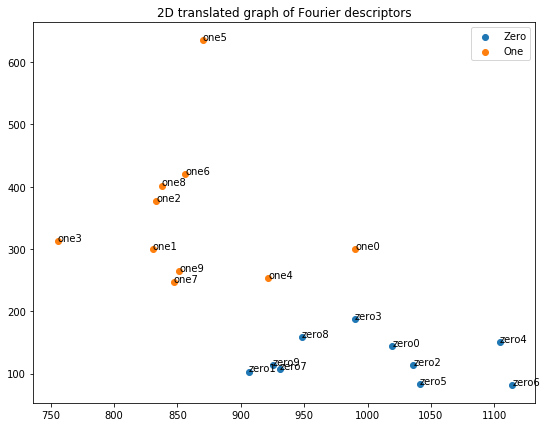

In [72]:
visFourier(contours_0, contours_1, 150, 'translated')

#### 1.2.4 Fourier descriptors by scaling images for **two times**

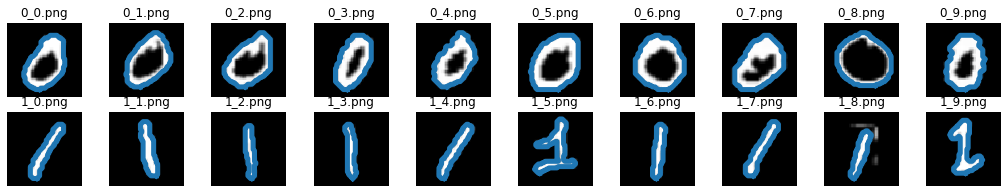

In [73]:
# Here we just zoom in with 2 times, since zoom out may cause contour extraction problems
level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []
scale = 2

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = transform.rescale(im, scale)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = transform.rescale(im, scale)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

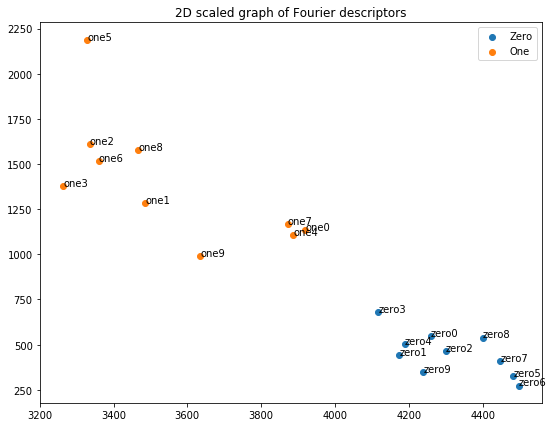

In [74]:
visFourier(contours_0, contours_1, scale*150, 'scaled')

### 1.3 Additional method(s)
Add your implementation and discussion

#### 1.3.1 PCA

In [23]:
from sklearn.decomposition import PCA
def PCA2d(x):
    # The shape of x should be (num_samples, num_features)
    pca = PCA(n_components=2)
    pca.fit(x)
    feature = pca.transform(x)
    return feature

Text(0.5, 1.0, 'First Two Features from PCA')

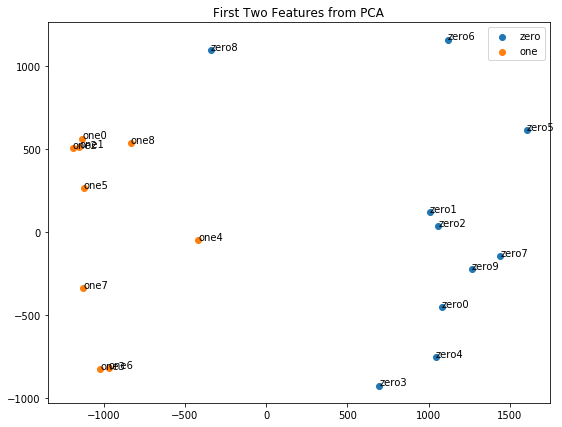

In [75]:
all_ims = np.concatenate((zeros_im, ones_im), 0).reshape((20,-1))
feature = PCA2d(all_ims)
plt.figure(figsize=(9, 7))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('First Two Features from PCA')

Text(0.5, 1.0, 'First Two Features from PCA after geometric transform')

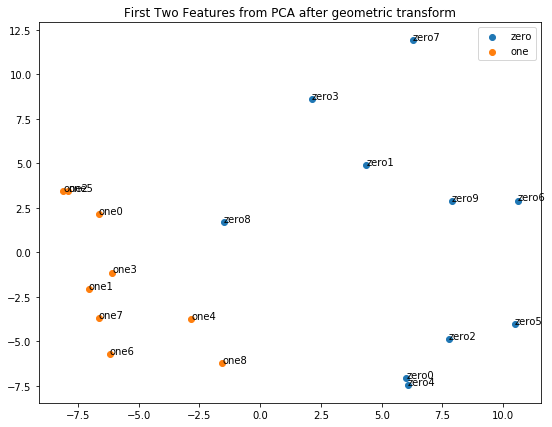

In [76]:
ims_t =[]
for im in np.concatenate((zeros_im, ones_im), 0):
    deg = np.random.randint(0,180)
    im = skimage.transform.rotate(im, deg)
    im = skimage.transform.rescale(im, 2)
    ims_t.append(im[np.newaxis, :, :])
ims_t = np.concatenate(ims_t, 0)
ims_t = ims_t.reshape((20,-1))
feature = PCA2d(ims_t)
plt.figure(figsize=(9, 7))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('First Two Features from PCA after geometric transform')

#### 1.3.2 Region-based descriptors (capacity and elongation)

In [26]:
from skimage.measure import perimeter
from skimage.filters import threshold_otsu

In [27]:
def capacity_feature(ims):
    perimeters = []
    area = []
    for i in range(20):
        im_b = ims[i]>threshold_otsu(ims[i])
        perimeters.append(perimeter(im_b))
        area.append(np.sum(im_b))
    perimeters = np.array(perimeters)
    area = np.array(area)
    capacity = (perimeters)**2 / area
    return capacity

In [28]:
def findBoundingBox(im):
    '''
        Find bouding box of maximum component in image.
    '''
    im = im > threshold_otsu(im)
    label_img = skimage.measure.label(im)
    prop = skimage.measure.regionprops(label_img)
    area = []
    for p in prop:
        area.append(p.area)
    p = prop[np.argmax(area)]
    box_area = (p['bbox'][3]-p['bbox'][1]) * (p['bbox'][2]-p['bbox'][0])
    return p, box_area

def elongation(im):
    '''
        Enumerate to find the oriented bounding box having maximum width/height ratio.
        From 0 to 360 degrees, we rotate 10 degrees every time and calculate the ratio.
    '''
    ratios = []
    ps = []
    areas = []
    degrees = list(range(0, 361, 10))
    for degree in degrees:
        im_r = transform.rotate(im, degree)
        im_r = im_r > threshold_otsu(im_r)
        p_temp, box_area = findBoundingBox(im_r)
        width, height = p_temp['bbox'][3]-p_temp['bbox'][1], p_temp['bbox'][2]-p_temp['bbox'][0]
        ratio = max(width, height) / min(width, height)
        areas.append(width*height)
        ps.append(p_temp)
        ratios.append(ratio)
    ind_max = np.argmax(ratios)
    r = ratios[ind_max]
    return r

In [29]:
cap = capacity_feature(np.concatenate((zeros_im, ones_im), 0)).reshape((-1,1))
el = []
for im in np.concatenate((zeros_im, ones_im), 0):
    el.append(elongation(im))
el = np.array(el).reshape((-1,1))
feature = np.concatenate((cap, el), 1)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


Text(0.5, 1.0, 'First Two Features from region-based method')

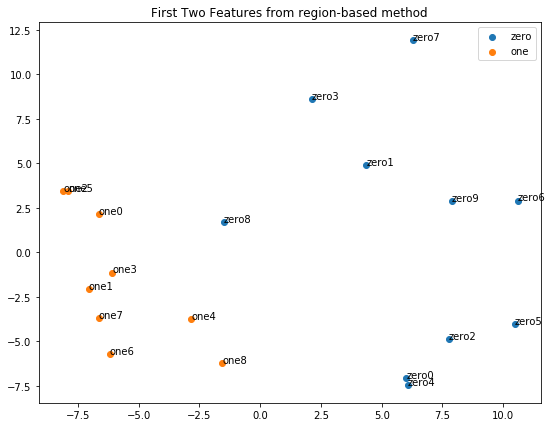

In [77]:
plt.figure(figsize=(9, 7))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('First Two Features from region-based method')

In [31]:
ims_t = []
for im in np.concatenate((zeros_im, ones_im), 0):
    deg = np.random.randint(0,180)
    im = skimage.transform.rotate(im, deg)
    im = skimage.transform.rescale(im, 2)
    ims_t.append(im[np.newaxis, :, :])
ims_t = np.concatenate(ims_t)

In [32]:
cap = capacity_feature(ims_t).reshape((-1,1))
el = []
for im in ims_t:
    el.append(elongation(im))
el = np.array(el).reshape((-1,1))
feature = np.concatenate((cap, el), 1)

Text(0.5, 1.0, 'First Two Features from region-based method after geometric transform')

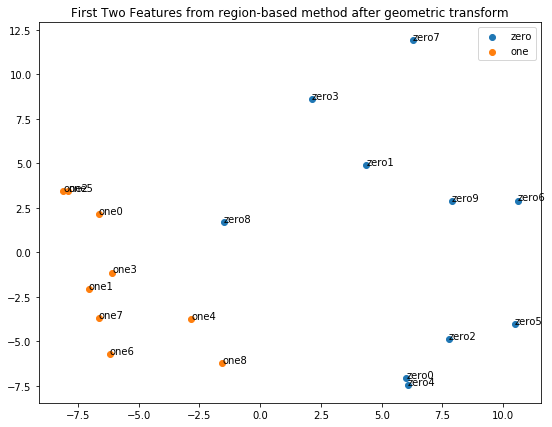

In [78]:
plt.figure(figsize=(9, 7))
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))
plt.title('First Two Features from region-based method after geometric transform')

#### Conclusion:
- From 2D graph of Fourier descriptors of **orginal images**, we can see that if we tune a good parameter of **Fourier transform frequency**, two classes of images can be seperated well.
- From 2D graph of Fourier descriptors of **rotated images**, with the same parameter(**Fourier transform frequency**), we find that the images become not as well separatable as orginal images, especially for the **5th** and **9th** images of ones. However, this result is reasonable since we can see that the **5th** and **9th** ones are actually in a different writing way compared with others.
- Similarly, in 2D graph of Fourier descriptors of **scaled images**, **5th** and **9th** ones are not well separatable for the same reason as above. 
- For 2D graph of Fourier descriptors of **translated images**, as long as we keep the all pixels of the numbers in the images(keep the shape infomation), the two classes are separatable. However, both two classes(cluster) have a large variation (nodes are not very concentrated).

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

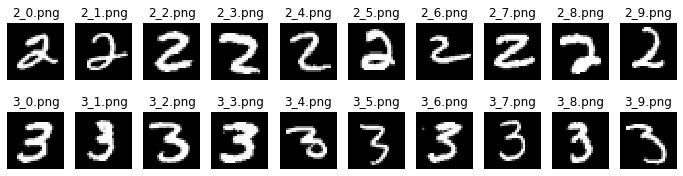

In [35]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [79]:
def visFourier_p2(contours_0, contours_1, contours_2, contours_3,  max_freq=150, text='Origin', component_1=1, component_2=2):
    '''
        contours_0: Contour list of zero images
        contours_1: Contour list of one images
        contours_2: Contour list of two images
        contours_3: Contour list of three images
        max_freq: The frequecy of fourier transformation
        component_1, component_2: Two components of Fourier desciptors used for classfication.
    '''
    # Fourier transformation for images
    zeros_dft, ones_dft, twos_dft, threes_dft = [], [], [], []
    zeros_mag, ones_mag, twos_mag, threes_mag = [], [], [], []

    # Set the freqency for the Fourier transformation
    for zero, one in zip(contours_0, contours_1):
        zero = [np.complex(cord[0], cord[1]) for cord in zero]
        zero_dft = np.fft.fft(zero, n=max_freq)
        zeros_dft.append(zero_dft)
        zeros_mag.append((np.abs(zero_dft[component_1]), np.abs(zero_dft[component_2])))

        one = [np.complex(cord[0], cord[1]) for cord in one]
        one_dft = np.fft.fft(one, n=max_freq)
        ones_dft.append(one_dft)
        ones_mag.append((np.abs(one_dft[component_1]), np.abs(one_dft[component_2])))
    
    for two, three in zip(contours_2, contours_3):
        two = [np.complex(cord[0], cord[1]) for cord in two]
        two_dft = np.fft.fft(two, n=max_freq)
        twos_dft.append(two_dft)
        twos_mag.append((np.abs(two_dft[component_1]), np.abs(two_dft[component_2])))

        three = [np.complex(cord[0], cord[1]) for cord in three]
        three_dft = np.fft.fft(three, n=max_freq)
        threes_dft.append(three_dft)
        threes_mag.append((np.abs(three_dft[component_1]), np.abs(three_dft[component_2])))

    # Visualize the first two components of Fourier descriptors
    plt.figure(figsize=(9, 7))
    plt.scatter([cord[0] for cord in zeros_mag], [cord[1] for cord in zeros_mag], label='Zero')
    plt.scatter([cord[0] for cord in ones_mag], [cord[1] for cord in ones_mag], label='One')
    plt.scatter([cord[0] for cord in twos_mag], [cord[1] for cord in twos_mag], label='Two')
    plt.scatter([cord[0] for cord in threes_mag], [cord[1] for cord in threes_mag], label='Three')
    plt.legend()
    plt.title("2D " + text + " graph of Fourier descriptors")
    for i, (zero, one) in enumerate(zip(zeros_mag, ones_mag)):
        plt.annotate('zero'+str(i), (zero[0], zero[1]), )
        plt.annotate('one'+str(i), (one[0], one[1]))
    for i, (two, three) in enumerate(zip(twos_mag, threes_mag)):
        plt.annotate('two'+str(i), (two[0], two[1]), )
        plt.annotate('three'+str(i), (three[0], three[1]))
    plt.show()


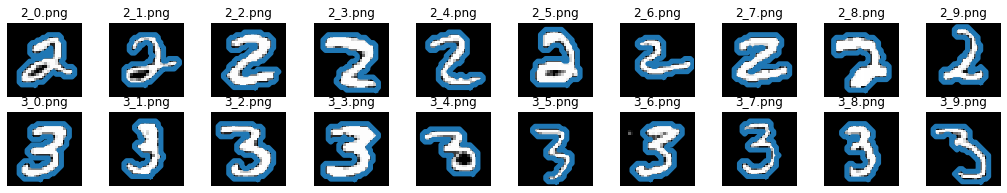

In [80]:
import numpy as np
import skimage.transform as transform
from skimage.measure import find_contours

level = 0.01
fig, axes = plt.subplots(2, len(twos_im), figsize=(18, 3))
contours_2, contours_3 = [], []

for ax, im, nm in zip(axes[0], twos_im, twos_names):
    contour = findContour(im, 0.5)
    contours_2.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], threes_im, threes_names):
    contour = findContour(im, 0.5)
    contours_3.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

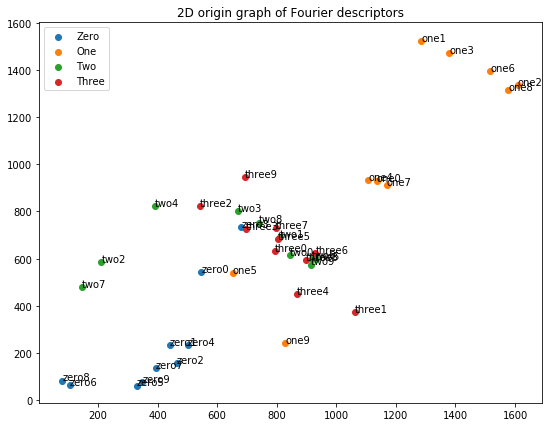

In [81]:
visFourier_p2(contours_0, contours_1,contours_2, contours_3, 150, 'origin')

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here